In [1]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
from tqdm import tqdm
import datetime as dt
from collections import Counter
from time import time

# text processing
import spacy
nlp = spacy.load('de')
from  nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover
from lda_functions import dict_pruning, party_substituter, sparse_text

In [2]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [2]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [3]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda_duples.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data_dup = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [29]:
len(all_data_dup)

334070

In [4]:
save = False

path_com_corpus = '../Data/lda_nlp_stem_ccorpus.pkl'
path_corpus = '../Data/lda_nlp_stem_corpus'
path_dic = '../Data/lda_nlp_stem_dic.pkl'

if save:
    text = all_data.loc[:, 'clean_text'].map(lambda x: x.lower()).map(party_substituter)

    document = []

    for row in text.iteritems():
        index, data = row
        document.append(data)
    
    lengths = len(document)
    corpus_full = []
    tick = time()
    for i, term in enumerate(document):
        corpus_full.append(sparse_text(term, nlp))
        print('{}/{}'.format(i, lengths), end='\r')
        if i % 5000 == 0:
            t1 = (time() - tick)/60
            print('Took {:.2f} min for {} loops'.format(t1, i))
    print('The entire process took {:.2f} min'.format((time() - tick)/60))

    
    corpus = dict_pruning(corpus_full, 10)

    common_dictionary = corpora.Dictionary(corpus, prune_at=100000)

    common_corpus = [common_dictionary.doc2bow(row) for row in corpus]

    
    with open(path_com_corpus, 'wb') as fid:
        pickle.dump(common_corpus, fid)
    with open(path_dic, 'wb') as fid:
        pickle.dump(common_dictionary, fid)
    with open(path_corpus, 'wb') as fid:
        pickle.dump(corpus, fid)       

else:
    with open(path_com_corpus, 'rb') as fid:
        common_corpus = pickle.load(fid)
    with open(path_dic, 'rb') as fid:
        common_dictionary = pickle.load(fid)
    with open(path_corpus, 'rb') as fid:
        corpus = pickle.load(fid)

In [7]:
all_data_dup.duplicated('clean_text').sum() + all_data.shape[0]

334070

In [5]:
all_data.shape,all_data_dup.shape

((115745, 8), (334070, 8))

In [5]:
path = '../Models/lda_nlp_stemmed_lda-model83.pkl'
with open(path, 'rb') as fid:
    lda = pickle.load(fid)

In [6]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [7]:
save_topics = False
path = '../Data/lda_nonlp_stemmed_topics_dupl.pkl'

if save_topics:
    
    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=corpus)
    # Format
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    # reindex the initial dataframe, make list of initial df and topics df and concatenate both
    all_data_reindexed = all_data.reset_index(drop=True)
    df_list = [df_dominant_topic,all_data_reindexed]
    full_df = pd.concat(df_list, axis=1)
    # make the resulting dataframe datetime indexed again and throw away unwanted columns
    full_df.index = full_df['created_at']
    full_df = full_df.drop(['stemmed', 'tags', 'parties', 'full_text', 'created_at', 'mentions'], axis=1)
    # show
    full_df.head()

    with open(path, 'wb') as fid:
        pickle.dump(full_df, fid)

else:
    with open(path, 'rb') as fid:
        full_df = pickle.load(fid)

In [8]:
all_merged = all_data_dup.merge(full_df, on='clean_text', ).set_index('created_at')

In [114]:
lda[common_corpus][0]

([(8, 0.57940906)],
 [(0, [32]), (1, [8]), (2, [41]), (3, [8]), (4, [41]), (5, [33])],
 [(0, [(32, 0.99999994)]),
  (1, [(8, 5.0)]),
  (2, [(41, 1.0)]),
  (3, [(8, 1.9999999)]),
  (4, [(41, 0.99999994)]),
  (5, [(33, 2.0)])])

In [128]:
common_corpus

[[(0, 1), (1, 5), (2, 1), (3, 2), (4, 1), (5, 2)],
 [(6, 1), (7, 1)],
 [(8, 1)],
 [(9, 1)],
 [(10, 1)],
 [(11, 1), (12, 1)],
 [(13, 1), (14, 1), (15, 1), (16, 1)],
 [(17, 1), (18, 1), (19, 1), (20, 1)],
 [(5, 1), (21, 1), (22, 1), (23, 1)],
 [(11, 1), (24, 1)],
 [(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(32, 1), (33, 1), (34, 1)],
 [(13, 1), (14, 1), (15, 1), (16, 1)],
 [(11, 1), (35, 1)],
 [(36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)],
 [(42, 1), (43, 1), (44, 1)],
 [(11, 1), (39, 1)],
 [(38, 1), (45, 1), (46, 1), (47, 1)],
 [(11, 1), (15, 1), (16, 1), (48, 1)],
 [(5, 1), (12, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 3)],
 [],
 [(54, 1), (55, 1)],
 [(56, 1)],
 [(11, 1), (26, 1), (57, 1), (58, 1), (59, 1)],
 [],
 [(60, 1), (61, 1), (62, 1)],
 [(5, 1), (63, 1), (64, 1), (65, 1), (66, 1)],
 [(67, 1), (68, 1)],
 [(17, 1), (18, 1), (19, 1), (20, 1)],
 [(11, 1), (69, 1)],
 [(70, 1)],
 [(7, 1), (71, 1), (72, 1), (73, 1)],
 [(11, 1), (35, 1)],
 [(74, 1)],

In [186]:
the_idx = 400
print([common_dictionary[x[0]] for x in common_corpus[the_idx]])
print(lda[common_corpus[the_idx]])

['fluechtling', 'pfann', 'hoeh', 'horrend', 'klageverfahr', 'laufzeit', 'untergetaucht']
([(6, 0.2825074), (41, 0.28250742)], [(2, [41]), (11, [18]), (449, [6]), (450, [6]), (451, [41]), (452, [76]), (453, [24])], [(2, [(41, 1.0)]), (11, [(18, 1.0)]), (449, [(6, 1.0)]), (450, [(6, 1.0)]), (451, [(41, 1.0)]), (452, [(76, 0.99999994)]), (453, [(24, 0.99999994)])])


In [189]:
lda.show_topic(6)

[('aufsteh', 0.31936166),
 ('beweg', 0.2571457),
 ('irgendwi', 0.06978123),
 ('oeffent', 0.060914353),
 ('vorh', 0.037162177),
 ('vollm', 0.034164388),
 ('spalt', 0.02786088),
 ('jemal', 0.026641078),
 ('wagenknecht', 0.025121212),
 ('websit', 0.019817451)]

In [195]:
for tt in range(83):
    if 'pfann' in [x[0] for x in lda.show_topic(tt)]:
        print(tt)

18


In [185]:
common_dictionary[969]

'ebenfall'

In [10]:
len(all_merged)

334070

In [11]:
all_merged.shape

(334070, 13)

In [12]:
all_data_dup.shape

(334070, 8)

In [13]:
all_data.shape

(115745, 8)

In [14]:
full_df.shape

(115745, 7)

In [98]:
all_merged.head()

,full_text,tags,mentions,clean_text,parties,stemmed,user_id,topic,Dominant_Topic
created_at,,,,,,,,,
2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794,foo,27.0
2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794,foo,27.0
2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794,foo,27.0
2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794,foo,27.0
2018-08-02 00:00:32,@bembelpix @AfD_Hessen NoAFD schreiben aber ke...,[],"[bembelpix, AfD_Hessen]",NoAFD schreiben aber keine Argumente li...,[AfD],noafd schreib aber kein argument lief ...,702527680722419712,foo,35.0


In [93]:
all_merged.Dominant_Topic.value_counts(dropna=False)

NaN      138469
 23.0     22492
 30.0      8022
 43.0      6965
 61.0      5490
 72.0      4891
 35.0      4787
 6.0       4168
 17.0      4050
 0.0       3932
 52.0      3786
 11.0      3729
 21.0      3572
 7.0       3345
 50.0      3151
 39.0      3031
 12.0      3005
 74.0      2987
 73.0      2956
 32.0      2947
 54.0      2849
 28.0      2773
 20.0      2753
 63.0      2560
 5.0       2485
 3.0       2436
 57.0      2398
 37.0      2389
 10.0      2379
 33.0      2236
          ...  
 66.0      1284
 14.0      1253
 76.0      1245
 78.0      1244
 38.0      1204
 46.0      1193
 71.0      1178
 49.0      1121
 34.0      1120
 51.0      1096
 82.0      1083
 40.0      1007
 45.0       999
 48.0       977
 18.0       972
 58.0       966
 22.0       951
 84.0       890
 70.0       823
 80.0       822
 41.0       783
 53.0       781
 44.0       778
 77.0       728
 24.0       668
 47.0       651
 26.0       642
 13.0       607
 27.0       559
 83.0       344
Name: Dominant_Topic, Le

In [ ]:
topic_counts_dedupl = all_merged.groupby(all_merged.index.date)['Dominant_Topic'].value_counts().reset_index(name='counts')


In [34]:
topic_counts

,Dominant_Topic,counts
level_0,,
2018-08-02,18.0,1559
2018-08-02,8.0,1037
2018-08-02,19.0,727
2018-08-02,33.0,567
2018-08-02,79.0,483
2018-08-02,49.0,252
2018-08-02,76.0,242
2018-08-02,41.0,192
2018-08-02,0.0,181


In [28]:
full_df.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,clean_text,user_id
created_at,,,,,,,
2018-08-02 00:00:14,0,8.0,0.5794,"freidemokrat, christsozial, christdemokrat, li...","[migrant, fluechtling, christsozial, christsoz...",Fuer Sami A macht man Rundfluege gute ...,884513792062881794
2018-08-02 00:00:32,1,26.0,0.4806,"off, normal, argument, schwaech, insgesamt, gr...","[nopfann, argument]",NoAFD schreiben aber keine Argumente li...,702527680722419712
2018-08-02 00:00:32,2,70.0,0.9243,"zukunft, illegal, rein, gespraech, ministerin,...",[wuerttemberg],Ich kenne nur die REPs Baden Wuer...,3438043463
2018-08-02 00:01:33,3,17.0,0.9243,"umfrag, aussag, monat, allgemein, frau, denk, ...",[dritt],Drittens in kauf nehmen ist ungleich ...,846319908254367744
2018-08-02 00:02:08,4,68.0,0.9243,"merkel, wert, toll, ziel, bundeswehr, ebenfall...",[wert],Damit wir die Werte AfD besser verstehe...,165708897


In [22]:
def topic_plot(df):
    dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dates = df.index.unique()
    
#     df = dfin.groupby(dfin.index.date)['Dominant_Topic'].value_counts().reset_index(name='counts')
#     df = df.set_index(pd.DatetimeIndex(df['level_0'])).drop(columns='level_0')
    
    
    fig, ax = plt.subplots(len(dates), 1, figsize=(20, 30))

    for i, date in enumerate(dates):
        ax[i].bar(df.loc[date, 'Dominant_Topic'], df.loc[date, 'counts'], label=date) 
        ax[i].set_ylim(0, 2000)
        ax[i].set_title('{} {}'.format(dow[date.dayofweek], date.date()))
        ax[i].set_ylabel('Mention count')
        ax[i].set_xlim(0.5, len(df['Dominant_Topic'].unique()))
    plt.xlabel('Topic number')
    plt.show()

In [11]:
topic_counts_full = full_df.groupby(full_df.index.date)['Dominant_Topic'].value_counts().reset_index(name='counts')

topic_counts_full = topic_counts_full.set_index(pd.DatetimeIndex(topic_counts_full['level_0'])).drop(columns='level_0')

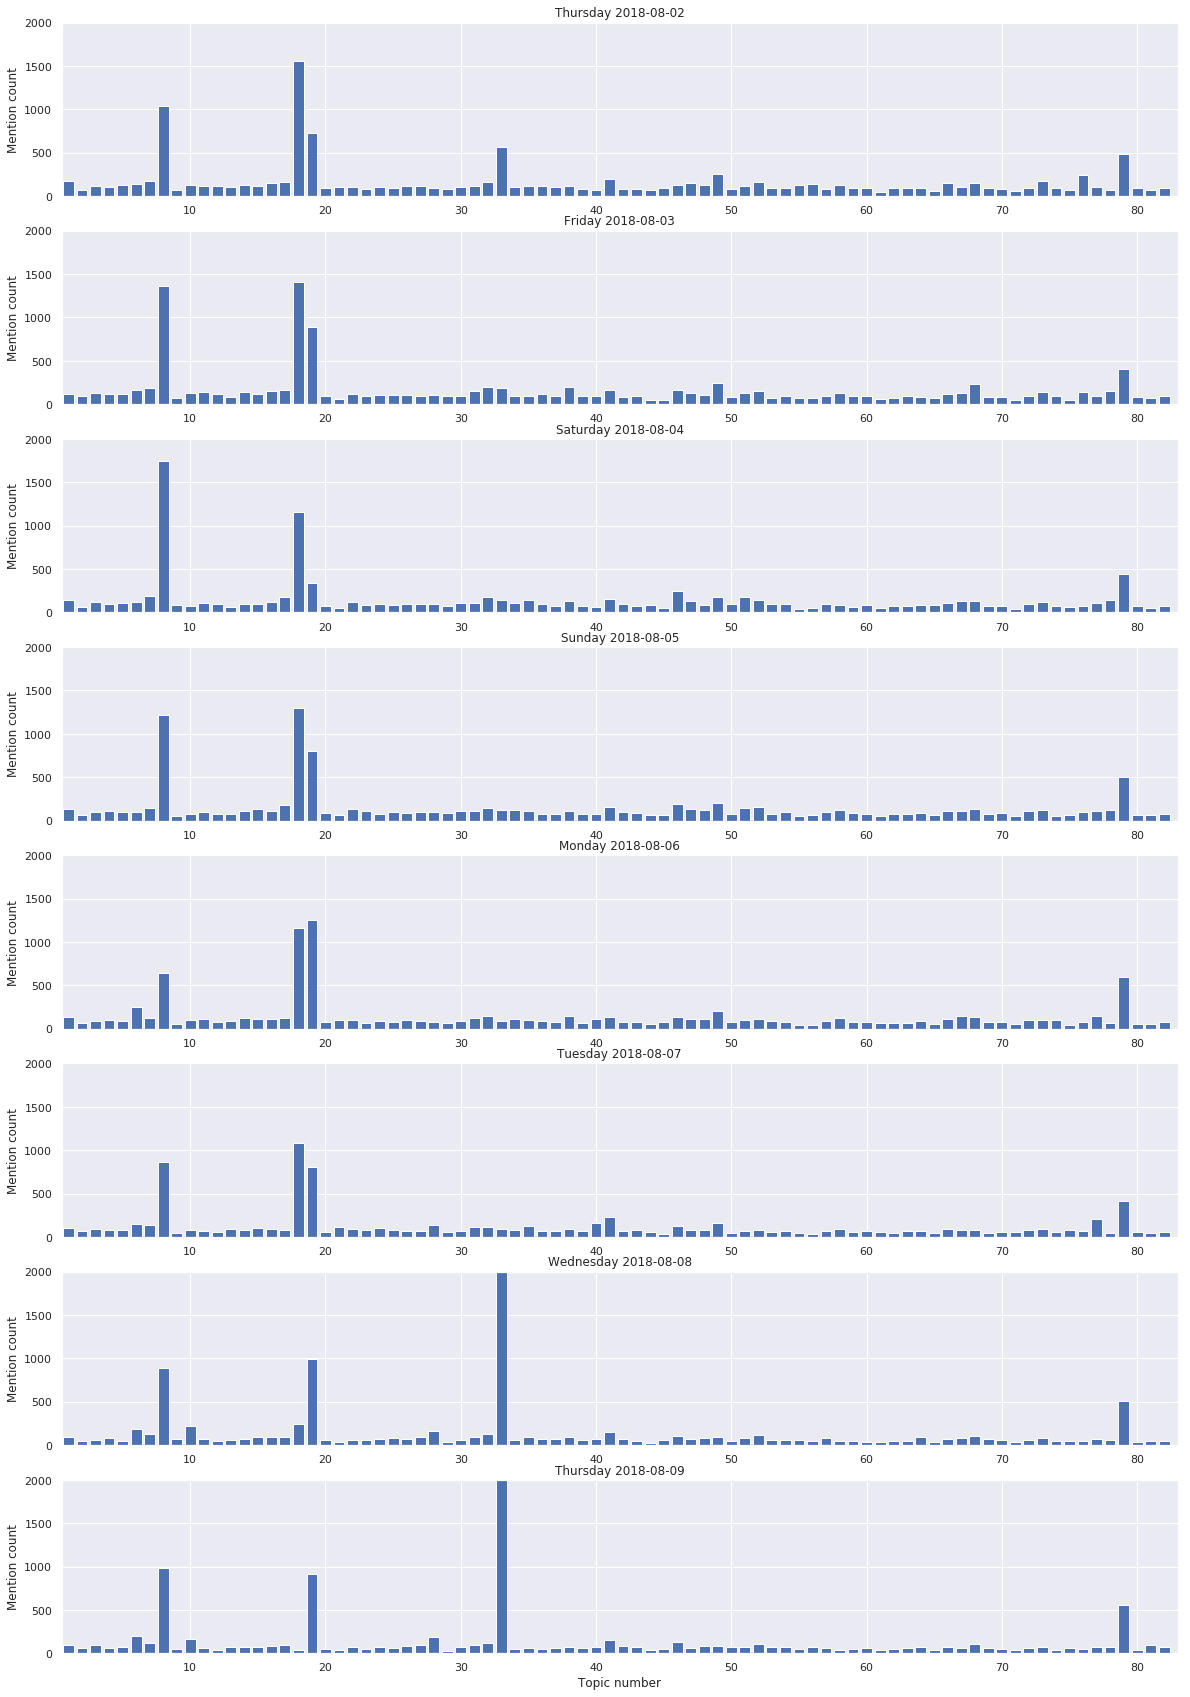

,Dominant_Topic,counts
level_0,,
2018-08-02,18.0,1559
2018-08-02,8.0,1037
2018-08-02,19.0,727
2018-08-02,33.0,567
2018-08-02,79.0,483
2018-08-02,49.0,252
2018-08-02,76.0,242
2018-08-02,41.0,192
2018-08-02,0.0,181


In [24]:
topic_plot(topic_counts_full)

In [14]:
topic_counts_merged = all_merged.groupby(all_merged.index.date)['Dominant_Topic'].value_counts().reset_index(name='counts')

topic_counts_merged = topic_counts_merged.set_index(pd.DatetimeIndex(topic_counts_merged['level_0'])).drop(columns='level_0')

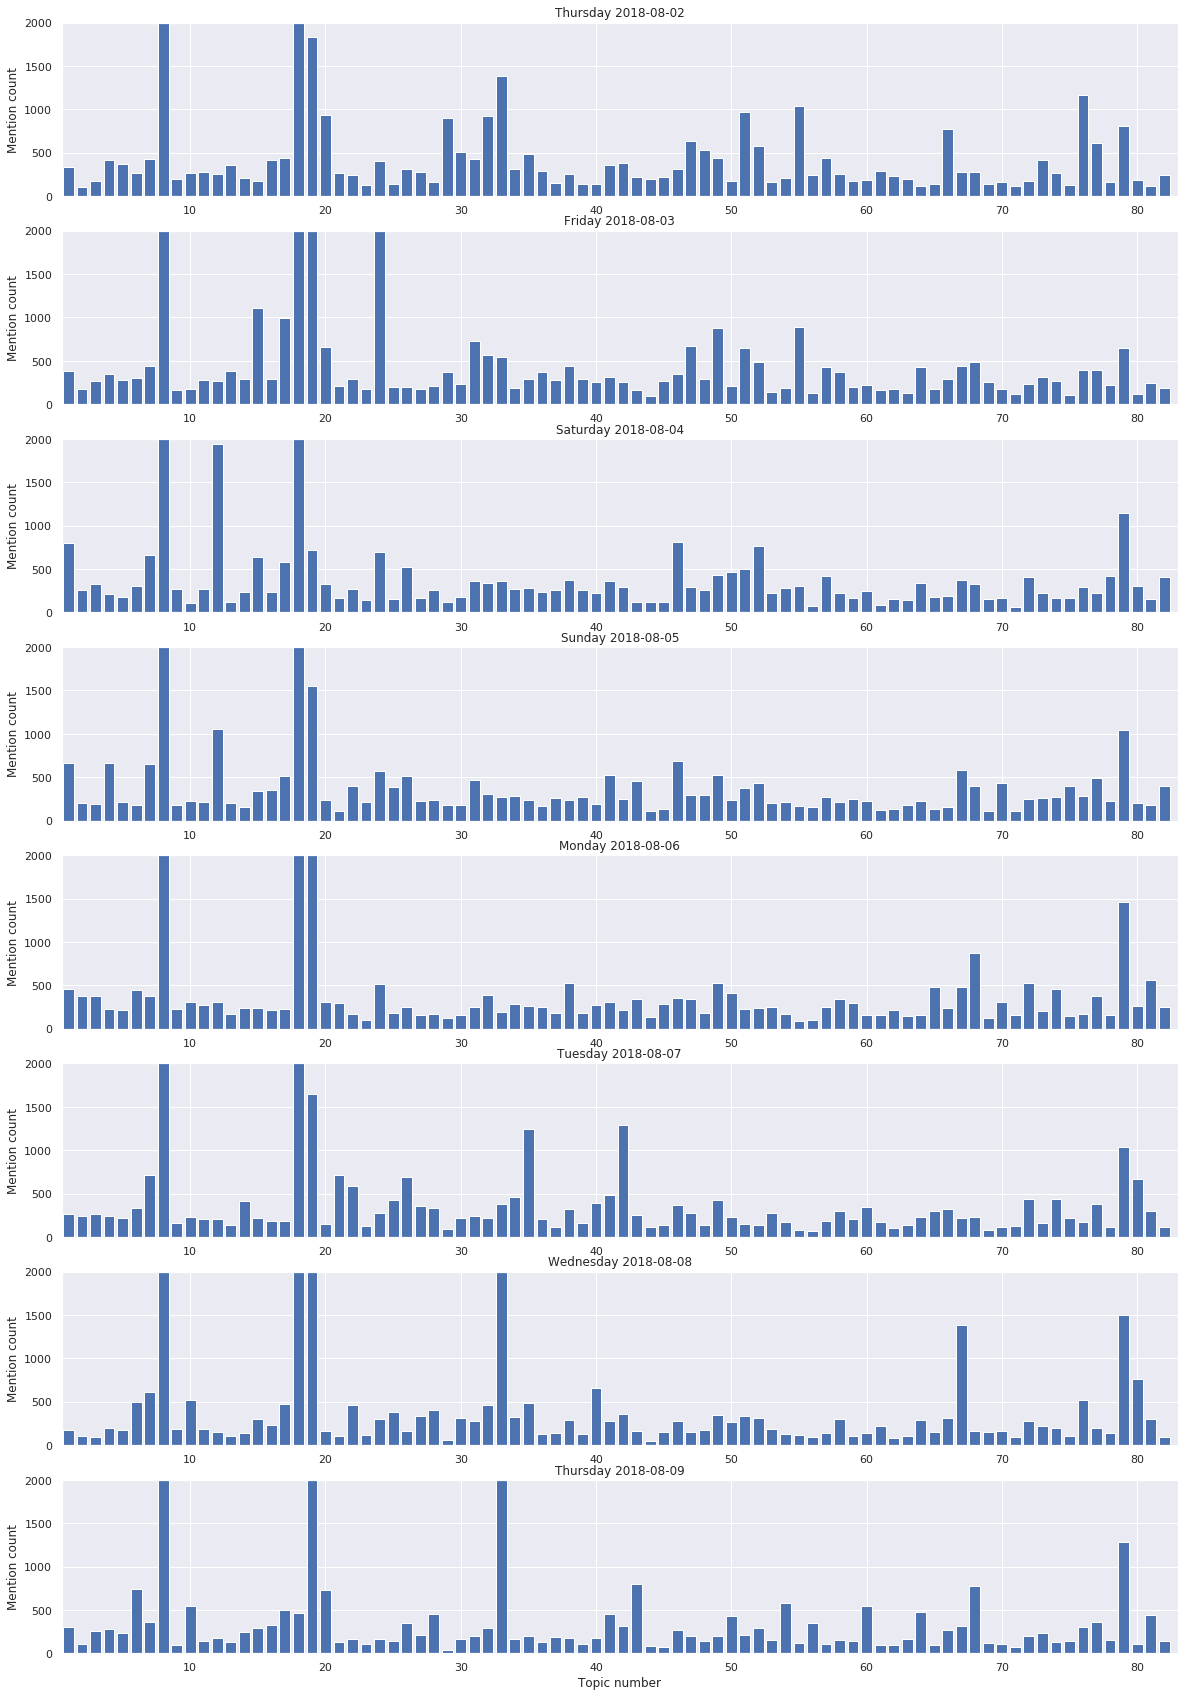

,Dominant_Topic,counts
level_0,,
2018-08-02,18.0,3431
2018-08-02,8.0,2743
2018-08-02,19.0,1838
2018-08-02,33.0,1386
2018-08-02,76.0,1167
2018-08-02,55.0,1042
2018-08-02,51.0,963
2018-08-02,20.0,938
2018-08-02,32.0,922


In [23]:
topic_plot(topic_counts_merged)

In [28]:
all_merged.Dominant_Topic.value_counts(dropna=False)

NaN      55599
 18.0    25899
 8.0     22735
 33.0    18824
 19.0    15104
 79.0     8925
 24.0     4939
 12.0     4369
 7.0      4227
 67.0     4084
 0.0      4002
 17.0     3917
 49.0     3763
 68.0     3516
 20.0     3507
 32.0     3494
 35.0     3484
 46.0     3412
 51.0     3394
 1.0      3375
 42.0     3365
 15.0     3302
 76.0     3293
 52.0     3238
 41.0     3085
 6.0      3056
 77.0     3041
 26.0     3002
 31.0     2951
 47.0     2857
         ...  
 30.0     1961
 3.0      1946
 14.0     1945
 54.0     1945
 27.0     1911
 29.0     1900
 5.0      1890
 82.0     1846
 11.0     1840
 36.0     1759
 65.0     1657
 70.0     1625
 78.0     1602
 13.0     1600
 53.0     1593
 2.0      1569
 37.0     1563
 39.0     1535
 59.0     1528
 9.0      1477
 75.0     1413
 45.0     1391
 61.0     1307
 56.0     1226
 62.0     1203
 63.0     1203
 69.0     1131
 23.0     1116
 44.0      896
 71.0      853
Name: Dominant_Topic, Length: 84, dtype: int64

In [27]:
full_df.Dominant_Topic.value_counts(dropna=False)

NaN      24059
 8.0      8739
 18.0     7953
 19.0     6708
 33.0     6242
 79.0     3910
 49.0     1418
 41.0     1343
 6.0      1290
 46.0     1235
 32.0     1209
 7.0      1196
 68.0     1086
 17.0     1072
 0.0      1059
 52.0     1041
 1.0      1007
 38.0      965
 28.0      962
 10.0      961
 16.0      915
 51.0      911
 77.0      903
 73.0      898
 31.0      895
 47.0      872
 66.0      846
 35.0      840
 15.0      838
 67.0      835
         ...  
 23.0      629
 13.0      624
 37.0      621
 43.0      616
 53.0      613
 20.0      596
 82.0      590
 60.0      587
 59.0      578
 50.0      576
 70.0      575
 39.0      572
 69.0      566
 63.0      561
 21.0      557
 74.0      550
 2.0       528
 29.0      527
 62.0      520
 81.0      509
 56.0      507
 80.0      492
 9.0       487
 55.0      485
 45.0      477
 75.0      454
 65.0      452
 44.0      444
 61.0      416
 71.0      395
Name: Dominant_Topic, Length: 84, dtype: int64

In [196]:
def print_largest_topics(topicsdf, fulldf, topic_prob=0.85, n_text=5):
    largest_tpcs = topicsdf.copy().reset_index().reset_index()
    frequent_topcs = largest_tpcs.groupby('level_0')['counts'].nlargest(5).reset_index().merge(
                 largest_tpcs[['index', 'Dominant_Topic']], left_on='level_1', right_on='index').drop(
                 columns='level_1')
    frequent_topcs_list = frequent_topcs.Dominant_Topic.unique()
    
    for topic in frequent_topcs_list:
        print('-----------------------------------------------------------------------------')
        print(topic, fulldf[['Keywords']][fulldf['Dominant_Topic'] == topic].values[0])
        print('-----------------------------------------------------------------------------')
        print(fulldf[['Topic_Perc_Contrib', 'clean_text']][(fulldf['Dominant_Topic'] == topic) & (fulldf['Topic_Perc_Contrib'] > topic_prob)].values[:n_text])

print_largest_topics(topic_counts, full_df, topic_prob=0.7, n_text=5)

-----------------------------------------------------------------------------
23.0 ['waehl, waehlt, stimmt, konservativ, partei, nam, umfrag, brandenburg, beid, ueberzeug']
-----------------------------------------------------------------------------
[[0.7325999736785889 'Hey    fick  euch   Nazi  Fotzen ']
 [0.7337999939918518
  '   Wir  haben  Norweger   Hollaender   Ost   asiaten  etc   Pp     Menschen  die  sich  wunderbar  integrieren  lassen   Also  ja   Diese  Parasiten  hingegen  sind  der  Untergang  dieser  Gesellschaft  ']
 [0.9225999712944031
  'Die  AfD  ist  die  einzige  Partei  die  man  noch  waehlen  kann   einLink ']
 [0.9225999712944031
  '   Historiker  Wolffsohn   Empoerte  Gegner  staerken  AfD  einLink ']
 [0.9225999712944031
  '     Der  Mann  wird  bestraft  fuer  das  zerschneiden  der  Deutschland  Fahne  und  unsere  Kanzlerin  reisst  ihrem  Mini  ']]
-----------------------------------------------------------------------------
39.0 ['rot, recht, faschist,

[[0.9596999883651733
  '   AfD  deckt  auf       Euro  Kosten  fuer  Mias  Moerder  vor  Mord  in  nur  eineinhalb      Jahren  einLink ']
 [0.9225999712944031
  '   Und  warum  haben  Sie  das  klug  werden  bis  jetzt  so  gluecklich  vermieden   AfD  Anhaenger  die  mir  die  Welt  erklaeren  wollen   Also  ein  Brauner  der  mir  die  Farblehre  erklaeren  will   Lieber  nicht      einLink ']
 [0.9596999883651733
  '   Der  Reiche  bin  ich   Die  Regierung  nimmt  Dir  die  Wohnung  weg  fuer  Migranten    ']
 [0.9596999883651733
  ' Es  geht  keine  Angst  in  Deutschland  um   Die  Angst  wird  von  AFD  und  CSU  behauptet   Ohne  Euch  waere  dieses  Land  angstfrei  ']
 [0.9225999712944031
  'Gespraeche  mit  der  AfD   Druck  auf  Maassen  waechst    WELT  einLink ']]
-----------------------------------------------------------------------------
56.0 ['journalist, absolut, islamist, groko, weiterhin, einsetz, ermordet, kuemm, gefall, gaest']
----------------------------------

[[0.9225999712944031
  'AfD  Kompakt   Zivile  Seenotretter  mitverantwortlich  fuer  Tote  im  Mittelmeer  einLink  einLink ']
 [0.9596999883651733
  '  In  jeder  demokratischen  Partei  wuerde  jemand  wie  Steinke  umgehend  seiner  Posten  enthoben  und  ausgeschlossen   Nicht  so  bei  der  AfD   die  Rechtsradikalismus  nicht  nur  toleriert   sondern  als  zentrale  Parteistroemung  ansieht  ']
 [0.9596999883651733
  '   Die   berichtet  heute  ueber  angeblichen  Tipp  von  Maassen    moege  den   AfD  Landesverband  Saar  maessigen   Hintergr  ']
 [0.9225999712944031
  '  Die  sind  nicht  witzig   Die  sind  zum  Heulen    Leersatz  des  Tages   Bitte  bei  Migraene  das  Kopfschuettelverbot  auch  dann  beachten   wenn  Sie  einen   AFD  Tweet  lesen    Neunmalklug   AusGruenden  mangelnder  Pietaet    ArmleuchterFuerDeutschland ']
 [0.8658999800682068
  '   Schon  damals   als  die  AfD  noch  NSDAP  hiess   war  sie  keine  Alternative   sondern  eine  Katastrophe  fuer  

In [197]:
all_merged[all_merged.Dominant_Topic == 23]

,full_text,tags,mentions,clean_text,parties,stemmed,user_id,topic,Dominant_Topic
created_at,,,,,,,,,
2018-08-02 00:28:22,@OomenBerlin Die gesitigen Verwandten der #Afd...,"[Afd, DieGruenen]",[OomenBerlin],Die gesitigen Verwandten der Afd von ...,"[AfD, Gruene]",die gesit verwandt der afd von diegru...,755877740071489536,foo,23.0
2018-08-02 00:46:13,RT @realJohr: .......die CSU wird der Afd imme...,[],[realJohr],die CSU wird der Afd immer aeh...,"[AfD, CSU]",die csu wird der afd imm aehnl...,81011743,foo,23.0
2018-08-02 06:56:34,RT @realJohr: .......die CSU wird der Afd imme...,[],[realJohr],die CSU wird der Afd immer aeh...,"[AfD, CSU]",die csu wird der afd imm aehnl...,580192769,foo,23.0
2018-08-02 07:26:33,RT @realJohr: .......die CSU wird der Afd imme...,[],[realJohr],die CSU wird der Afd immer aeh...,"[AfD, CSU]",die csu wird der afd imm aehnl...,718833722,foo,23.0
2018-08-02 09:43:09,RT @realJohr: .......die CSU wird der Afd imme...,[],[realJohr],die CSU wird der Afd immer aeh...,"[AfD, CSU]",die csu wird der afd imm aehnl...,943442071377113088,foo,23.0
2018-08-02 10:03:01,RT @realJohr: .......die CSU wird der Afd imme...,[],[realJohr],die CSU wird der Afd immer aeh...,"[AfD, CSU]",die csu wird der afd imm aehnl...,2192907408,foo,23.0
2018-08-02 10:32:59,RT @realJohr: .......die CSU wird der Afd imme...,[],[realJohr],die CSU wird der Afd immer aeh...,"[AfD, CSU]",die csu wird der afd imm aehnl...,2763842220,foo,23.0
2018-08-02 17:23:21,RT @realJohr: .......die CSU wird der Afd imme...,[],[realJohr],die CSU wird der Afd immer aeh...,"[AfD, CSU]",die csu wird der afd imm aehnl...,482805390,foo,23.0
2018-08-02 18:49:39,RT @realJohr: .......die CSU wird der Afd imme...,[],[realJohr],die CSU wird der Afd immer aeh...,"[AfD, CSU]",die csu wird der afd imm aehnl...,964630198573588481,foo,23.0
